# Training a Convolutional Neural Network to Classify Traffic Signs, and Dealing with Class Imbalance

Marc Burlina

## Introduction

In order for autonmous vehicles to safely navigate our roads, it is neccesary that they are able to identify and differentiate between traffic signs. The German Traffic Sign Recognition Benchmark (GTSRB) is a large multi-class image classification dataset containing 39,270 images of german traffic signs from 43 classes. As its name hints, it is frequently used as a benchmark for evaluating multi-class image classification models. Note that this dataset's classes are not balanced, i.e. some classes appear very frequently while others less so.

Deep neural networks are able to perform computer vision tasks like image classification very well, so they are the dominant approach to most computer vision machine learning problems today. In particular, a neural network architecture called the convolutional neural network performs exceptionally well at computer vision tasks. 

In this tutorial, we will train a convolutional neural network to classify images from GTSRB, and evaluate the effectiveness of a technique to address the class imbalance present in the dataset.

## Getting the Dataset and Exploring it

First we import all of the libraries we will use:

In [1]:
import torch, torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

We will need GPU access to train our models:

In [2]:
# Try to access GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using {device}")

using cuda


Create variable storing num_classes for convenience:

In [3]:
N_CLASS = 43

First, we download GTSRB and put split it into train/test/validation sets:

In [4]:
train_dataset = datasets.GTSRB(root=".", split="train", download=True)
test_dataset = datasets.GTSRB(root=".", split="test", download=True)

Let's look at the size of each of our datasets:

In [5]:
print(f"Size of train set {len(train_dataset)}")
print(f"Size of test set {len(test_dataset)}")

Size of train set 26640
Size of test set 12630


In total, there are 26,640 + 12,630 = 39,270 images in GTSRB. This means we are using roughly 70% of the data for training and 30% for testing. While train/test splits such as 80/20 and 90/10 are also common, our 70/30 split gives us a sufficient number of images in both our training and testing sets (> 10,000 images in each) so it is fine for our purposes.

Now let's visualize some images from the dataset. More specifically, let's look at an image from each of the 43 classes in our dataset. The dataset's labels are numeric in range [0, 42], so we'll need to use the dictionary from [this GitHub repo](https://github.com/magnusja/GTSRB-caffe-model/blob/master/labeller/main.py) to convert them to strings:

In [6]:
label_map = {
    '0': '20_speed',
    '1': '30_speed',
    '2': '50_speed',
    '3': '60_speed',
    '4': '70_speed',
    '5': '80_speed',
    '6': '80_lifted',
    '7': '100_speed',
    '8': '120_speed',
    '9': 'no_overtaking_general',
    '10': 'no_overtaking_trucks',
    '11': 'right_of_way_crossing',
    '12': 'right_of_way_general',
    '13': 'give_way',
    '14': 'stop',
    '15': 'no_way_general',
    '16': 'no_way_trucks',
    '17': 'no_way_one_way',
    '18': 'attention_general',
    '19': 'attention_left_turn',
    '20': 'attention_right_turn',
    '21': 'attention_curvy',
    '22': 'attention_bumpers',
    '23': 'attention_slippery',
    '24': 'attention_bottleneck',
    '25': 'attention_construction',
    '26': 'attention_traffic_light',
    '27': 'attention_pedestrian',
    '28': 'attention_children',
    '29': 'attention_bikes',
    '30': 'attention_snowflake',
    '31': 'attention_deer',
    '32': 'lifted_general',
    '33': 'turn_right',
    '34': 'turn_left',
    '35': 'turn_straight',
    '36': 'turn_straight_right',
    '37': 'turn_straight_left',
    '38': 'turn_right_down',
    '39': 'turn_left_down',
    '40': 'turn_circle',
    '41': 'lifted_no_overtaking_general',
    '42': 'lifted_no_overtaking_trucks'
}

Now we can plot our images:

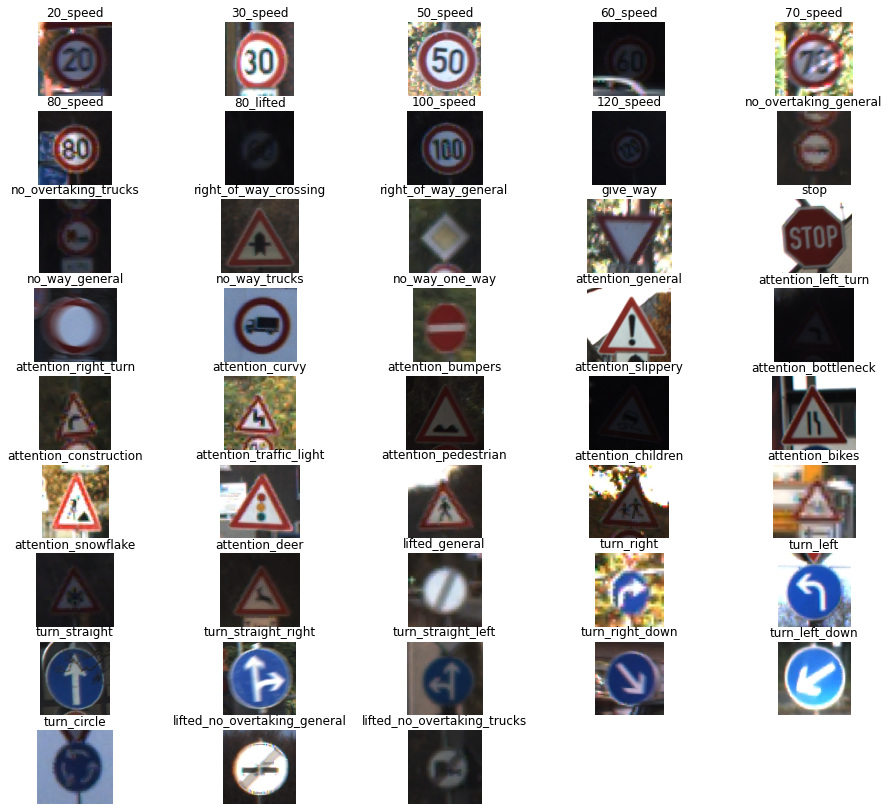

In [7]:
# Get image from each class in our dataset

# Dict storing images. imgs[i] is an image of class i.
# Use dict instead of array b/c storing imgs.
imgs = {}

# Iterate thru test dataset (because it is smaller than train) 
# and grab an image from each class
for img, label in test_dataset:
  if label not in imgs:
    imgs[label] = img

# Verify that we have collected an image from each class
# The datasets labels should be in range [0, 42]
assert set(imgs.keys()) == set(range(N_CLASS))

# Plot each image and label its class
fig = plt.figure(figsize = (16, 16))
rows = 10
cols = 5
for i in range(N_CLASS):
  fig.add_subplot(rows, cols, i + 1)
  plt.imshow(imgs[i])
  plt.title(label_map[str(i)]) # label keys are strings
  plt.axis('off') # Hides ticks

Notice that the images are taken under a wide variety of lighting conditions. Some of the images are taken at night (e.g. attention_slippery) and others are taken during the day (e.g. 30_speed). Additionally, some of the signs are covered by shadows (e.g. 70_speed) and others are reflecting glare from a light source (e.g. turn_left_down). This variety in our training data will improve our model's ability to make accurate predictions in poor lighting conditions, which is important for autonomous vehicles since they must be capable of navigating safely under non-ideal conditions.

Next, lets look at the distributions of each class in our training and test dataset. We will visualize these distributions using a double bar plot created using [this function from StackOverflow](https://stackoverflow.com/a/60270421), which is copied below:

In [8]:
def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())

Now we can create our graph:

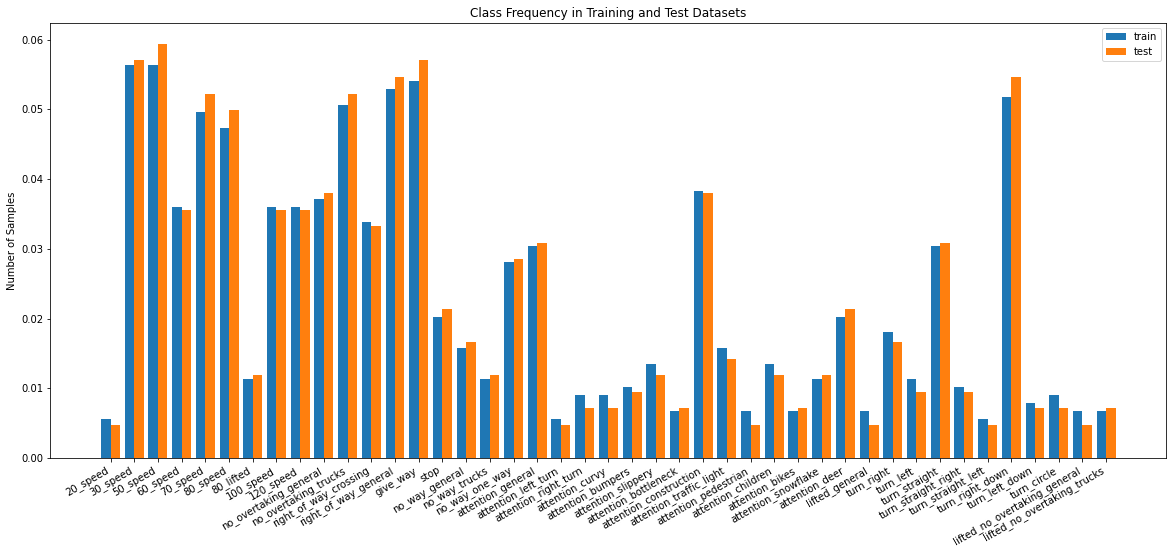

In [9]:
# Get number of samples per class in train set

# Arrays storing class distribution. ith entry = # occurences of class i.
train_freq = np.zeros(N_CLASS)
test_freq = np.zeros(N_CLASS) 

# Compute distributions
for _, label in train_dataset:
  train_freq[label] += 1

for _, label in test_dataset:
  test_freq[label] += 1

# Normalize
train_freq = train_freq / np.sum(train_freq)
test_freq = test_freq / np.sum(test_freq)

# Create double bar plot
fig, ax = plt.subplots(figsize=(20,8))
bar_plot(ax, {"train" : train_freq, "test" : test_freq})

# Configure title, labels
ax.set_title("Class Frequency in Training and Test Datasets")
ax.set_ylabel("Number of Samples")
plt.xticks(range(N_CLASS), [label_map[str(i)] for i in range(N_CLASS)]) 
_ = plt.setp(ax.get_xticklabels(), rotation = 30, horizontalalignment='right') # assignment supresses unwanted output

Notice that in both our training and test sets, some classes occur very frequently while others rarely occur. This is called class imbalance (read about it [here](https://machinelearningmastery.com/what-is-imbalanced-classification/)) and can be very problematic. Because many performance metrics (e.g. accuracy) will weigh the classifier's performance on each class by the class's frequency, if we do not train our classifier carefully, it may be incentivized to learn features of the more common classes and ignore the less common ones. This could greatly harm our classifier's performance on underrepresented classes, which would make it difficult for an autonomous vehicle to identify certain traffic signs that are underrepresented in our dataset. Despite their underrepresentation, these traffic signs could be important for navigating safely, so we would like to perform well on them. 

There are many techniques to deal with class imbalance, but before we apply any, let's train a model as we would on a balanced dataset. It is possible that, even for underrepresented classes, there are enough samples for our model to perform well. After we train our model, we can analyze its performance on each class and see if we need to directly address the imbalance problem.



## Training a Model I

We will use a convolutional neural network (CNN) for our experiments. The CNN is a neural network architecture that performs very well at computer vision tasks like image classification. As its name hints, its primary mechanism is an operation called convolution. Generally, the meaning of each pixel in an image is strongly influenced by its neigbors and not so strongly influenced by distant pixels. While a traditional fully-connected neural network would consider how all pixels in an image interact with each other, CNNs leverage this assumption by only considering local interactions between pixels. This is computationally cheaper and and allows CNNs to process large images. Check out [this article](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) for a detailed explanation of CNNs.

First, let's load our model via PyTorch:

In [10]:
resnet = models.resnet18(weights='IMAGENET1K_V1')

The CNN that we'll use is called is called ResNet-18. Unless you are an expert, it is generally better to use an existing neural network architecture than to try and create your own. ResNet-18 is the 18 layer version of ResNet, a popular architecture for computer vision tasks. There are variants of ResNet with more layers, but they require too much compute power to train. 

Notice we loaded our model with pretrained weights. More specifically, our model has already been trained on [ImageNet](https://www.image-net.org/), a large dataset of annotated images. This means our network already recognizes common features of images, which may help it learn our task better and more quickly. This trick is called transfer learning.

Let's look at our model's architecture:

In [11]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Notice our model has 20 convolution layers (18 if you don't count 1x1 convolutions) and ends with a fully connected layer with 1000 output nodes. However, we need our final layer to have 43 output nodes since we are dealing with 43 classes. Let's modify the network:

In [12]:
resnet.fc = torch.nn.Linear(512, 43) # New fc layer should have 43 output nodes

Now we can start preparing to train our network. We will need to apply some transformations to our training and test sets before we can feed them to our network. I obtained the below transformations from [this tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html). Note one of the transformations applied to our training dataset randomly flips an image. This is a form of data augmentation, a technique that increases the amount and variety of training data we have by applying transformations to existing data. This results in a more robust model. Read more about data augmentation [here](https://www.analyticsvidhya.com/blog/2021/05/image-classification-with-tensorflow-data-augmentation-on-streaming-data-part-2/#:~:text=What%20is%20Data%20Augmentation%3F,Image%20flip%2C%20and%20many%20more.).

In [13]:
# Create transforms
transforms = {
    'train': transforms.Compose([ # For training
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([ # For testing
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Re-initialize datasets to apply these transforms
train_dataset = datasets.GTSRB(root=".", split="train", download=True, transform=transforms['train'])
test_dataset = datasets.GTSRB(root=".", split="test", download=True, transform =transforms['test'])

Next we will create a dataloader for training and testing. These are wrappers around our datasets that serve images to our model in batches. I experimented with different batch sizes, but 16 seems to work okay.

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2) # Shuffle training data after each epoch
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

Now we can set some of the hyperparameters for training. We will train our neural network using gradient descent (you can learn more about it [here](https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21)) with a learning rate of 1e-3 (I did not tune the learning rate, 1e-3 is a commonly used value) for 10 epochs. Additionally, we'll use cross entropy loss as our loss function (this is a common loss function for classification). Finally, we will use the SGD optimizer with momentum 0.9 because this is the value used in the linked tutorial.

In [15]:
# Set hyperparameters
learn_rate = 1e-3
epochs = 10
loss_fxn = torch.nn.CrossEntropyLoss()

# Create optimizer
optimizer = optim.SGD(resnet.parameters(), lr=learn_rate, momentum=0.9)

Next we create functions that will train and test our model. Let's create a training function first:

In [16]:
# Trains model for an epoch, returns average loss and accuracy
def train(model, dataloader, loss_fxn, optimizer):
  running_loss = 0.0
  num_correct = 0  

  # Put model in training mode for batch norm and dropout layers
  model.train()
  
  # Iterate thru batches
  for inputs, labels in dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Zero parameter gradients since they accumulate
    optimizer.zero_grad()
  
    # Forward
    outputs = model(inputs)
    loss = loss_fxn(outputs, labels)

    # Backward
    loss.backward()
    optimizer.step()

    # Compute running loss, accuracy
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    num_correct += torch.sum(labels == preds).item()

  return  running_loss / len(dataloader.dataset), num_correct / len(dataloader.dataset)

And then a testing function:

In [17]:
# Tests model, returns prediction and ground truth for each test sample
def test(model, dataloader):
  # Store predictions, ground truth
  y_pred = []
  y_true = []

  # Put model in eval mode for batch norm and dropout layers
  model.eval()

  # Iterate thru batches
  for inputs, labels in dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward
    with torch.no_grad():
      output = model(inputs)

    # Convert output to 1d array of size 16
    output = torch.max(output, 1)[1].cpu().numpy()

    # Append output, labels to appropriate lists
    y_pred.extend(output)
    y_true.extend(labels.cpu().numpy())

  return y_pred, y_true

Finally, we create a function that trains our model for a given # of epochs and prints out the model's loss and accuracy for each epoch

In [18]:
# Train model for num_epochs epochs, print summary stats each epoch
# Returns loss and accuracy history so we can plot it
def train_epochs(model, train_dataloader, optimizer, loss_fxn, num_epochs):
  # Track loss, accuracy across epochs
  loss_history = []
  acc_history = []

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    
    # Train, validate
    train_loss, train_acc = train(model, train_dataloader, loss_fxn, optimizer)

    # Update history, print epoch summary
    loss_history.append(train_loss)
    acc_history.append(train_acc)
    print('loss: {:.4f} acc: {:.4f}'.format(train_loss, train_acc))

  # Return acc, loss history
  return acc_history, loss_history

Great! Now we can train our model!

In [19]:
# Move model to GPU
resnet = resnet.to(device)

# Train
acc_history, loss_history = train_epochs(resnet, train_dataloader, optimizer, loss_fxn, epochs)

Epoch 0/9
----------
loss: 0.9966 acc: 0.7301
Epoch 1/9
----------
loss: 0.3739 acc: 0.8883
Epoch 2/9
----------
loss: 0.3027 acc: 0.9081
Epoch 3/9
----------
loss: 0.2609 acc: 0.9196
Epoch 4/9
----------
loss: 0.2301 acc: 0.9294
Epoch 5/9
----------
loss: 0.2208 acc: 0.9321
Epoch 6/9
----------
loss: 0.1954 acc: 0.9395
Epoch 7/9
----------
loss: 0.1903 acc: 0.9408
Epoch 8/9
----------
loss: 0.1877 acc: 0.9410
Epoch 9/9
----------
loss: 0.1740 acc: 0.9463


Now let's plot our training accuracy and loss vs epoch:

Text(0.5, 0, 'Epoch')

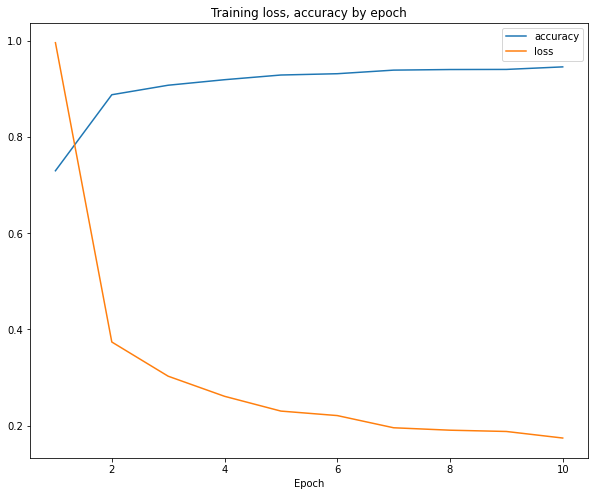

In [22]:
# Epochs
x = np.arange(1, 11)

# Plot lines for loss, acc
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(x, acc_history, label="accuracy")
ax.plot(x, loss_history, label="loss")
ax.legend()
ax.set_title("Training loss, accuracy by epoch")
ax.set_xlabel("Epoch")

Notice how our loss and accuracy improved rapidly in the first 2 epochs and after epoch 2 improved much slower.



## Evaluating Model I

Now let's evaluate our model on the test set:

In [23]:
# Test, get predictions and ground truth
y_pred, y_true = test(resnet, test_dataloader)

Let's create a normalized confusion matrix to analyze our results:

Text(86.09374999999999, 0.5, 'Actual label')

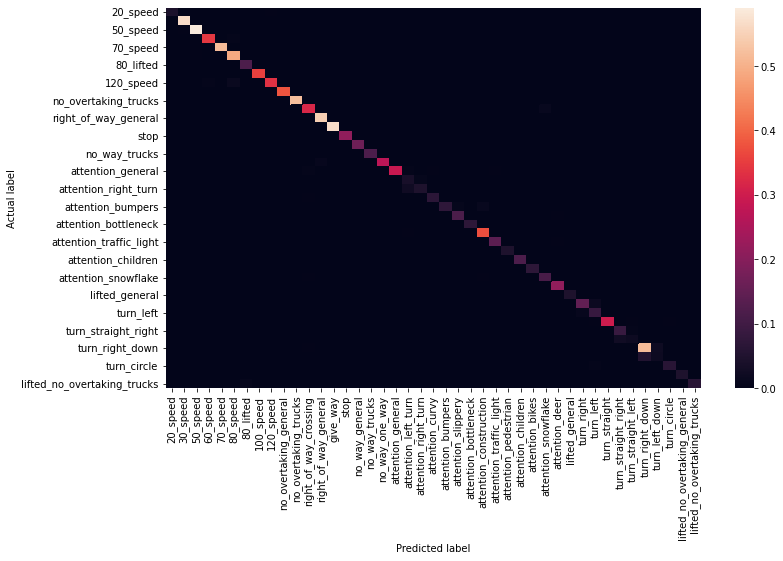

In [24]:
# Lots of help from https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

# Create confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Put into dataframe for easy plotting
names = [label_map[str(i)] for i in range(N_CLASS)]
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 10, index=names, columns=names)

# Plot as heatmap
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(df_cm, annot=False)
ax.set_xlabel("Predicted label")
ax.set_ylabel("Actual label")

Note that the heatmap is brightest along the diagonal. This is good and means that for each class i, our model predicts that samples actually belonging to i belong to i more often than predicting that they belong to another class. 

However, some diagonal values are very bright while others are dim. Let's try to figure out why! Remember that we define our model's recall for a class i by:

recall = true positives / (true positives + false negatives)

where i is the positive class and any class j =/= i is negative. You can think of recall as the model's accuracy on samples of class i. It turns out that each value along the diagonal corresponds to a class' recall, i.e. cf_matrix[i][i] = recall for class i. It it possible that our model is performing worse on classes with fewer training samples and better on classes with more training samples i.e. there is a positive correlation between class frequency and recall. Let's plot each class' frequency in the training dataset against its recall and see if they are correlated.

In [25]:
# Labels points in a scatter plot
# Copied from https://stackoverflow.com/questions/15910019/annotate-data-points-while-plotting-from-pandas-dataframe
def label_point(x, y, val, ax, shift=.002):
    a = pd.concat({'x': pd.Series(x), 'y': pd.Series(y), 'val': pd.Series(val)}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+shift, point['y'], str(point['val']))

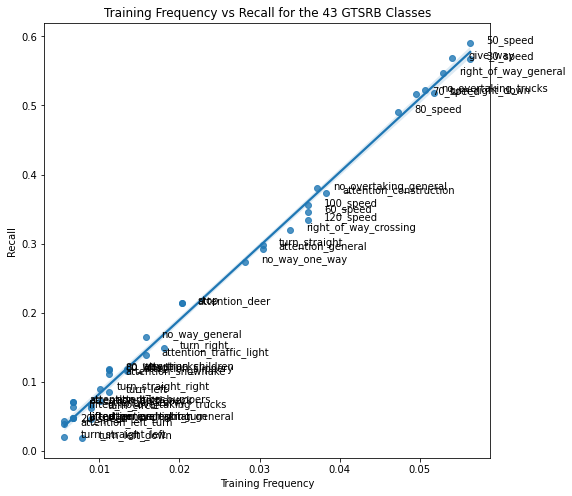

In [26]:
# Get diagonal entries (recall) of normalized confusion matrix as array
recall = np.diag(df_cm)

# Plot freq vs recall, add regression line
fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=train_freq, y=recall, data=["Training frequency", "Recall"])
ax.set_title("Training Frequency vs Recall for the 43 GTSRB Classes")
ax.set_xlabel("Training Frequency")
ax.set_ylabel("Recall")
label_point(train_freq, recall, names, ax)

There is a very clear positive correlation between training frequency and recall! It seems like it is worth trying some techniques to improve our model's performance on underrepresented classes. There are many techniques we could try (read about some [here](https://machinelearningmastery.com/what-is-imbalanced-classification/)) but in the interest of time, we'll only try one.

## Training a model II: Adressing Class imbalance

We will try to adress our class imbalance problem by introducing sample weights in our loss function. The idea is to weigh the loss computed on samples belonging to minority classes heavier than samples computed on majority classes. This incentivizes our model to learn the minority classes even though they may be greatly outnumbered by other classes. In our experiment, we will weigh each sample by the inverse of the training frequency of the class it belongs to. There are other weighting schemes we could use, but this is the simplest (check out [this article](https://medium.com/gumgum-tech/handling-class-imbalance-by-introducing-sample-weighting-in-the-loss-function-3bdebd8203b4) for more details). 

We train another model using our weighted loss. Like before, we use pretrained ResNet-18, cross entropy loss (but weighted this time) for our loss function, and SGD for our optimizer. We use the same learning rate and train for 10 epochs.

In [28]:
# Fetch model, move to GPU
weighted_resnet = models.resnet18(weights='IMAGENET1K_V1')
weighted_resnet.fc = torch.nn.Linear(512, 43)
weighted_resnet = weighted_resnet.to(device)

# Compute class weights
weights = 1 / train_freq
weights = weights / np.sum(weights) # Renormalize
weights = torch.tensor(weights, device=device).float() # convert to tensor, put on GPU

# Create weighted loss function
weighted_loss_fxn = torch.nn.CrossEntropyLoss(weight=weights)

# Create new optimizer
weighted_optimizer = optim.SGD(weighted_resnet.parameters(), lr=learn_rate, momentum=0.9)

# Train
acc_history, loss_history = train_epochs(weighted_resnet, train_dataloader, weighted_optimizer, weighted_loss_fxn, epochs)

Epoch 0/9
----------
loss: 1.1486 acc: 0.6750
Epoch 1/9
----------
loss: 0.4574 acc: 0.8612
Epoch 2/9
----------
loss: 0.3535 acc: 0.8913
Epoch 3/9
----------
loss: 0.2999 acc: 0.9063
Epoch 4/9
----------
loss: 0.2882 acc: 0.9113
Epoch 5/9
----------
loss: 0.2593 acc: 0.9193
Epoch 6/9
----------
loss: 0.2386 acc: 0.9257
Epoch 7/9
----------
loss: 0.2194 acc: 0.9294
Epoch 8/9
----------
loss: 0.2175 acc: 0.9293
Epoch 9/9
----------
loss: 0.2045 acc: 0.9322


Great! Let's save our model and then plot the training accuracy and loss:

In [29]:
# Save model
torch.save(weighted_resnet.state_dict(), 'weighted_resnet18_trained.pth')

Text(0.5, 0, 'Epoch')

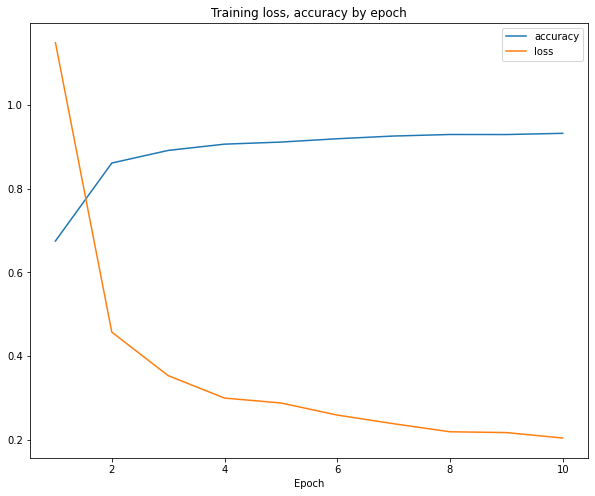

In [30]:
# Plot lines for loss, acc
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(x, acc_history, label="accuracy")
ax.plot(x, loss_history, label="loss")
ax.legend()
ax.set_title("Training loss, accuracy by epoch")
ax.set_xlabel("Epoch")

Our training loss and accuracy are slighly worse than our first model (e.g. our weighted model' accuracy peaks at 93.2% while our first model reaches 94.6%). Similar to our first model, loss and accuracy improve rapidly in the first couple epochs and then slow down.

## Evaluating a model II: Analyzing the Impact of Weighting

Now let's evaluate our weighted model on the test set:

In [31]:
# Test, get predictions and ground truth
y_pred_weighted, y_true_weighted = test(weighted_resnet, test_dataloader)

Let's look at our weighted model's confusion matrix:

Text(86.09374999999999, 0.5, 'Actual label')

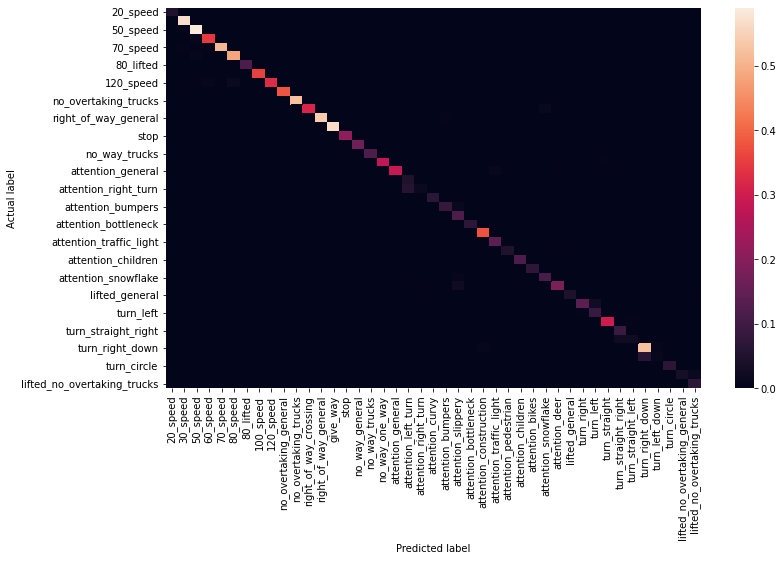

In [32]:
# Create confusion matrix
cf_matrix = confusion_matrix(y_true_weighted, y_pred_weighted)

# Put into dataframe for easy plotting
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 10, index=names, columns=names)

# Plot as heatmap
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(df_cm, annot=False)
ax.set_xlabel("Predicted label")
ax.set_ylabel("Actual label")

This looks very similar to our original confusion matrix, but it is difficult to interpret any changes in performance from it because its colormap may be different from the original's. A better way to compare performance on each class with our original model is to plot both models' recall on each class on a double bar graph:

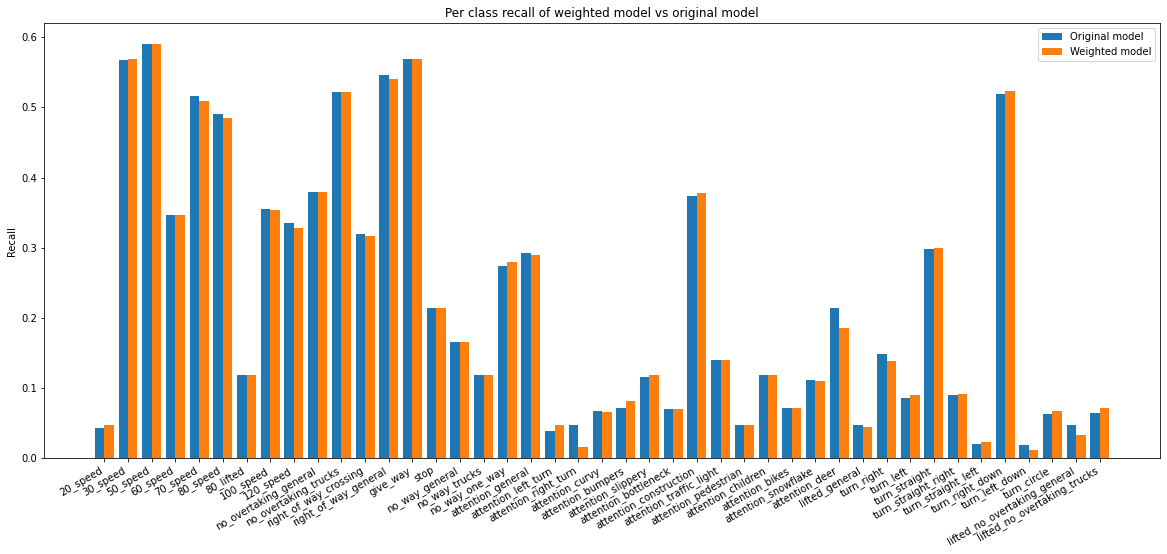

In [33]:
# Compute weighted recall
weighted_recall = np.diag(df_cm)

# Create double bar plot
fig, ax = plt.subplots(figsize=(20,8))
bar_plot(ax, {"Original model" : recall, "Weighted model" : weighted_recall})

# Configure title, labels
ax.set_title("Per class recall of weighted model vs original model")
ax.set_ylabel("Recall")
plt.xticks(range(N_CLASS), [label_map[str(i)] for i in range(N_CLASS)]) 
_ = plt.setp(ax.get_xticklabels(), rotation = 30, horizontalalignment='right') # assignment supresses unwanted output

It appears that recall improved for some classes, and worsened for others (but not drastically). We would expect that our weighting scheme would improve recall for minority classes and maybe slightly worsen it for more common classes. This seems true in some cases. For example, 20_speed is relatively infrequent and its performance increases with weighting. Howevever, this does not always happen. For example, attention_right_turn is also relatively infrequent but its recall decreases after weighting. To see if there is a relationship between class frequency and the impact of weighting on recall, lets plot the change in recall post weighting vs class training frequency. We would expect a negative correlation i.e. low frequency is associated with increase in recall, high frequency is associated with decrease in recall.

Text(0, 0.5, 'Change in recall (weighted - original)')

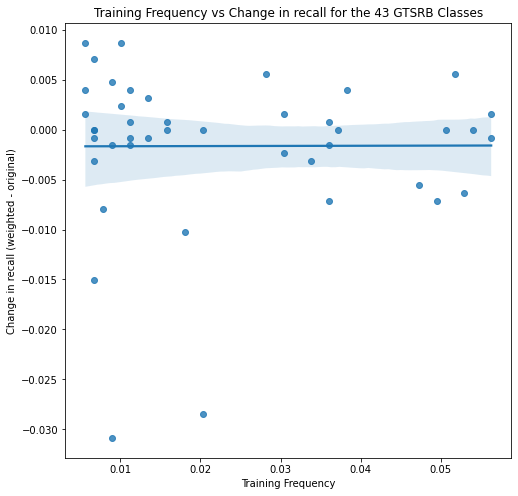

In [34]:
# Get change in recall
delta_recall = weighted_recall - recall

# Plot freq vs recall, add regression line
fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=train_freq, y=delta_recall, data=["Training frequency", "Change in recall (weighted - original)"])
ax.set_title("Training Frequency vs Change in recall for the 43 GTSRB Classes")
ax.set_xlabel("Training Frequency")
ax.set_ylabel("Change in recall (weighted - original)")

It appears that there is little correlation between training frequency and change in recall. It seems that weighting mostly improved recall for infrequent classes, although there are a few exceptions. For frequent classes, it appears that weighting did not significantly change their recall.

## Conclusion

We successfully trained a CNN on GTSRB and tried to adress the dataset's class imbalance by weighting our loss function. Overall, it seems like our weighting scheme may have yielded a small improvement to our model's performance on minority classes. We could try other techniques to address class imbalance such as different weighting schemes, sampling more image from minority classes, or other ways to augment our data set and introduce more minority examples. However, it is also possible that we simply have too few samples in our minority classes to expect our model to perform well on them, regardless of any techniques we apply.